In [5]:
from tensorflow import keras
import tensorflow as tf
class CustomModel(keras.Model):
    def train_step(self, data):
        print('hello')
        # Unpack the data. Its structure depends on your model and
        # on what you pass to `fit()`.
        x, y = data

        with tf.GradientTape() as tape:
            y_pred = self(x, training=True)  # Forward pass
            # Compute the loss value
            # (the loss function is configured in `compile()`)
            loss = self.compiled_loss(y, y_pred, regularization_losses=self.losses)

        # Compute gradients
        trainable_vars = self.trainable_variables
        gradients = tape.gradient(loss, trainable_vars)
        # Update weights
        self.optimizer.apply_gradients(zip(gradients, trainable_vars))
        # Update metrics (includes the metric that tracks the loss)
        self.compiled_metrics.update_state(y, y_pred)
        # Return a dict mapping metric names to current value
        return {m.name: m.result() for m in self.metrics}



In [6]:
import numpy as np

# Construct and compile an instance of CustomModel
inputs = keras.Input(shape=(32,))
outputs = keras.layers.Dense(1)(inputs)
model = CustomModel(inputs, outputs)
model.compile(optimizer="adam", loss="mse", metrics=["mae"])

# Just use `fit` as usual
x = np.random.random((1000, 32))
y = np.random.random((1000, 1))
model.fit(x, y, epochs=3)


Epoch 1/3
hello
hello
32/32 [==============================] - 0s 533us/step - loss: 2.1202 - mae: 1.3510
Epoch 2/3
32/32 [==============================] - 0s 513us/step - loss: 1.0347 - mae: 0.8850
Epoch 3/3
32/32 [==============================] - 0s 557us/step - loss: 0.5210 - mae: 0.5916


In [7]:
tf.__version__

'2.2.0'

In [8]:
from tensorflow.keras import layers

# Create the discriminator
discriminator = keras.Sequential(
    [
        keras.Input(shape=(28, 28, 1)),
        layers.Conv2D(64, (3, 3), strides=(2, 2), padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(128, (3, 3), strides=(2, 2), padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.GlobalMaxPooling2D(),
        layers.Dense(1),
    ],
    name="discriminator",
)

# Create the generator
latent_dim = 128
generator = keras.Sequential(
    [
        keras.Input(shape=(latent_dim,)),
        # We want to generate 128 coefficients to reshape into a 7x7x128 map
        layers.Dense(7 * 7 * 128),
        layers.LeakyReLU(alpha=0.2),
        layers.Reshape((7, 7, 128)),
        layers.Conv2DTranspose(128, (4, 4), strides=(2, 2), padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2DTranspose(128, (4, 4), strides=(2, 2), padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(1, (7, 7), padding="same", activation="sigmoid"),
    ],
    name="generator",
)


In [10]:
discriminator.summary()

Model: "discriminator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 14, 14, 64)        640       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 7, 7, 128)         73856     
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 7, 7, 128)         0         
_________________________________________________________________
global_max_pooling2d (Global (None, 128)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 129       
Total params: 74,625
Trainable params: 74,625
Non-trainable params: 0
_________________________________________________

In [9]:
generator.summary()

Model: "generator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 6272)              809088    
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 6272)              0         
_________________________________________________________________
reshape (Reshape)            (None, 7, 7, 128)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 14, 14, 128)       262272    
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 28, 28, 128)       262272    
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 28, 28, 128)       0 

In [11]:

class GAN(keras.Model):
    def __init__(self, discriminator, generator, latent_dim):
        super(GAN, self).__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim

    def compile(self, d_optimizer, g_optimizer, loss_fn):
        super(GAN, self).compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn

    def train_step(self, real_images):
        if isinstance(real_images, tuple):
            real_images = real_images[0]
        # Sample random points in the latent space
        batch_size = tf.shape(real_images)[0]
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))

        # Decode them to fake images
        generated_images = self.generator(random_latent_vectors)

        # Combine them with real images
        combined_images = tf.concat([generated_images, real_images], axis=0)

        # Assemble labels discriminating real from fake images
        labels = tf.concat(
            [tf.ones((batch_size, 1)), tf.zeros((batch_size, 1))], axis=0
        )
        # Add random noise to the labels - important trick!
        labels += 0.05 * tf.random.uniform(tf.shape(labels))

        # Train the discriminator
        with tf.GradientTape() as tape:
            predictions = self.discriminator(combined_images)
            d_loss = self.loss_fn(labels, predictions)
        grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
        self.d_optimizer.apply_gradients(
            zip(grads, self.discriminator.trainable_weights)
        )

        # Sample random points in the latent space
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))

        # Assemble labels that say "all real images"
        misleading_labels = tf.zeros((batch_size, 1))

        # Train the generator (note that we should *not* update the weights
        # of the discriminator)!
        with tf.GradientTape() as tape:
            predictions = self.discriminator(self.generator(random_latent_vectors))
            g_loss = self.loss_fn(misleading_labels, predictions)
        grads = tape.gradient(g_loss, self.generator.trainable_weights)
        self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))
        return {"d_loss": d_loss, "g_loss": g_loss}



In [33]:
# Prepare the dataset. We use both the training & test MNIST digits.
batch_size = 64
(x_train, _), (x_test, _) = keras.datasets.mnist.load_data()
all_digits = np.concatenate([x_train, x_test])
all_digits = all_digits.astype("float32") / 255.0
all_digits = np.reshape(all_digits, (-1, 28, 28, 1))
dataset = tf.data.Dataset.from_tensor_slices(all_digits)
dataset = dataset.shuffle(buffer_size=1024).batch(batch_size)

gan = GAN(discriminator=discriminator, generator=generator, latent_dim=latent_dim)
gan.compile(
    d_optimizer=keras.optimizers.Adam(learning_rate=0.0003),
    g_optimizer=keras.optimizers.Adam(learning_rate=0.0003),
    loss_fn=keras.losses.BinaryCrossentropy(from_logits=True),
)

# To limit execution time, we only train on 100 batches. You can train on
# the entire dataset. You will need about 20 epochs to get nice results.
gan.fit(dataset.take(100), epochs=50)


Epoch 1/50
100/100 [==============================] - 72s 715ms/step - d_loss: 0.1621 - g_loss: 1.9352
Epoch 2/50
100/100 [==============================] - 74s 741ms/step - d_loss: 0.5306 - g_loss: 1.4436
Epoch 6/50
100/100 [==============================] - 74s 741ms/step - d_loss: 0.5289 - g_loss: 1.4047
Epoch 7/50
100/100 [==============================] - 72s 716ms/step - d_loss: 0.5665 - g_loss: 1.2997
Epoch 8/50
100/100 [==============================] - 74s 742ms/step - d_loss: 0.5071 - g_loss: 1.4315
Epoch 9/50
100/100 [==============================] - 71s 710ms/step - d_loss: 0.4576 - g_loss: 1.5860
Epoch 10/50
100/100 [==============================] - 77s 767ms/step - d_loss: 0.4961 - g_loss: 1.3511
Epoch 11/50
100/100 [==============================] - 72s 719ms/step - d_loss: 0.4309 - g_loss: 1.4811
Epoch 12/50
100/100 [==============================] - 72s 723ms/step - d_loss: 0.4345 - g_loss: 1.4818
Epoch 13/50
100/100 [==============================] - 75s 753ms/step 

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [23]:
import matplotlib.pyplot as plt
%matplotlib inline

In [46]:
random_latent_vectors = tf.random.normal(shape=(1, gan.latent_dim))

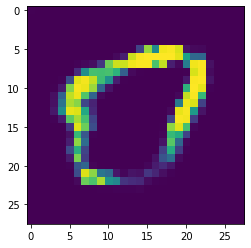

In [47]:
plt.imshow(tf.cast(generator(random_latent_vectors)[0,:,:,0]*255,tf.int32))

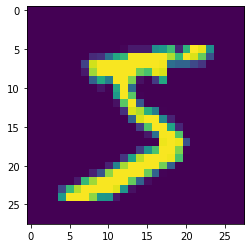

In [31]:
plt.imshow(x_train[0])